# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Standard Section 3: Multiple Linear Regression and Polynomial Regression 

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Abhimanyu (Abhi) Vasishth, Robbert (Rob) Struyven<br/>

<hr style='height:2px'>

In [3]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

For this section, our goal is to get you familiarized with Multiple Linear Regression. We have learned how to model data with kNN Regression and Simple Linear Regression and our goal now is to dive deep into Linear Regression.

Specifically, we will: 
    
- Load in the titanic dataset from seaborn
- Learn a few ways to plot **distributions** of variables using seaborn
- Learn about different **kinds of variables** including continuous, categorical and ordinal
- Perform single and multiple linear regression
- Learn about **interaction** terms
- Understand how to **interpret coefficients** in linear regression
- Look at **polynomial** regression
- Understand the **assumptions** being made in a linear regression model
- (Extra): look at some cool plots to raise your EDA game

![meme](../fig/meme.png)

In [4]:
# Data and Stats packages
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Extending Linear Regression

## Working with the Titanic Dataset from Seaborn

For our dataset, we'll be using the passenger list from the Titanic, which famously sank in 1912. Let's have a look at the data. Some descriptions of the data are at https://www.kaggle.com/c/titanic/data, and here's [how seaborn preprocessed it](https://github.com/mwaskom/seaborn-data/blob/master/process/titanic.py).

The task is to build a regression model to **predict the fare**, based on different attributes.

Let's keep a subset of the data, which includes the following variables: 

- age
- sex
- class
- embark_town
- alone
- **fare** (the response variable)

In [5]:
# Load the dataset from seaborn 
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [6]:
# checking for null values
chosen_vars = ['age', 'sex', 'class', 'embark_town', 'alone', 'fare']
titanic = titanic[chosen_vars]
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
age            714 non-null float64
sex            891 non-null object
class          891 non-null category
embark_town    889 non-null object
alone          891 non-null bool
fare           891 non-null float64
dtypes: bool(1), category(1), float64(2), object(2)
memory usage: 29.8+ KB


**Exercise**: check the datatypes of each column and display the statistics (min, max, mean and any others) for all the numerical columns of the dataset.

In [7]:
## your code here



In [8]:
# %load 'solutions/sol1.py'

**Exercise**: drop all the non-null *rows* in the dataset. Is this always a good idea?

In [9]:
## your code here



In [10]:
# %load 'solutions/sol2.py'

Now let us visualize the response variable. A good visualization of the distribution of a variable will enable us to answer three kinds of questions:

- What values are central or typical? (e.g., mean, median, modes)
- What is the typical spread of values around those central values? (e.g., variance/stdev, skewness)
- What are unusual or exceptional values (e.g., outliers)

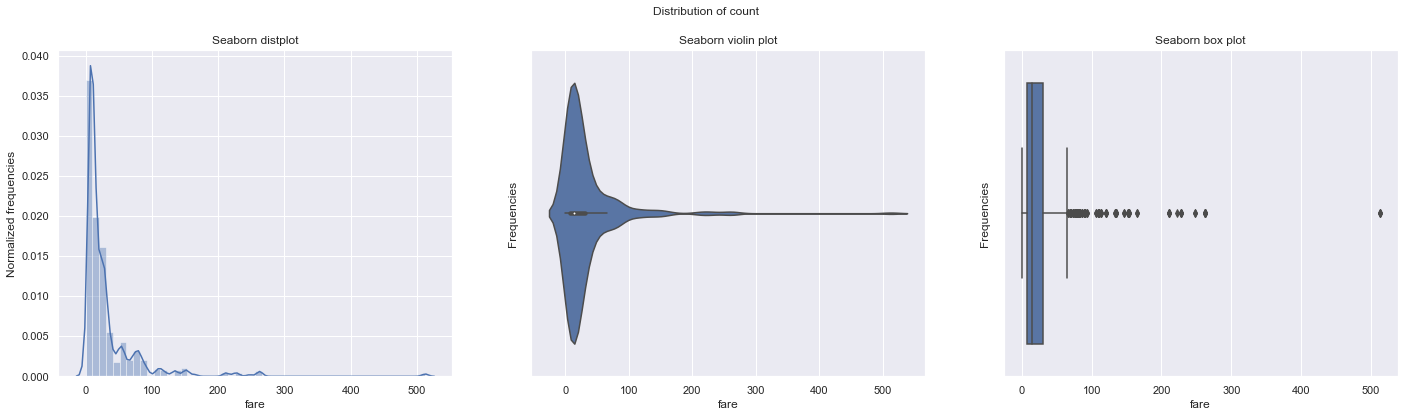

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
ax = ax.ravel()

sns.distplot(titanic['fare'], ax=ax[0])
ax[0].set_title('Seaborn distplot')
ax[0].set_ylabel('Normalized frequencies')

sns.violinplot(x='fare', data=titanic, ax=ax[1])
ax[1].set_title('Seaborn violin plot')
ax[1].set_ylabel('Frequencies')

sns.boxplot(x='fare', data=titanic, ax=ax[2])
ax[2].set_title('Seaborn box plot')
ax[2].set_ylabel('Frequencies')
fig.suptitle('Distribution of count');

How do we interpret these plots?

## Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split

titanic_train, titanic_test = train_test_split(titanic, train_size=0.7, random_state=99)
titanic_train = titanic_train.copy()
titanic_test = titanic_test.copy()
print(titanic_train.shape, titanic_test.shape)

(623, 6) (268, 6)


## Simple one-variable OLS

**Exercise**: You've done this before: make a simple model using the OLS package from the statsmodels library predicting **fare** using **age** using the training data. Name your model `model_1` and display the summary

In [13]:
from statsmodels.api import OLS
import statsmodels.api as sm

In [14]:
# Your code here



In [15]:
# %load 'solutions/sol3.py'

## Dealing with different kinds of variables

In general, you should be able to distinguish between three kinds of variables: 

1. Continuous variables: such as `fare` or `age`
2. Categorical variables: such as `sex` or `alone`. There is no inherent ordering between the different values that these variables can take on. These are sometimes called nominal variables. Read more [here](https://stats.idre.ucla.edu/other/mult-pkg/whatstat/what-is-the-difference-between-categorical-ordinal-and-interval-variables/). 
3. Ordinal variables: such as `class` (first > second > third). There is some inherent ordering of the values in the variables, but the values are not continuous either. 

*Note*: While there is some inherent ordering in `class`, we will be treating it like a categorical variable.

In [16]:
titanic_orig = titanic_train.copy()

Let us now examine the `sex` column and see the value counts.

In [17]:
titanic_train['sex'].value_counts()

male      397
female    226
Name: sex, dtype: int64

**Exercise**: Create a column `sex_male` that is 1 if the passenger is male, 0 if female. The value counts indicate that these are the two options in this particular dataset. Ensure that the datatype is `int`.

In [18]:
# your code here



In [4]:
# %load 'solutions/sol4.py'
../solutions/sol4.py

SyntaxError: invalid syntax (<ipython-input-4-d7a31078bb4e>, line 2)

Do we need a `sex_female` column, or a `sex_others` column? Why or why not?

Now, let us look at `class` in greater detail.

In [20]:
titanic_train['class_Second'] = (titanic_train['class'] == 'Second').astype(int)
titanic_train['class_Third'] = 1 * (titanic_train['class'] == 'Third') # just another way to do it

In [21]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 557 to 641
Data columns (total 8 columns):
age             501 non-null float64
sex             623 non-null object
class           623 non-null category
embark_town     622 non-null object
alone           623 non-null bool
fare            623 non-null float64
class_Second    623 non-null int32
class_Third     623 non-null int32
dtypes: bool(1), category(1), float64(2), int32(2), object(2)
memory usage: 30.5+ KB


In [22]:
# This function automates the above:
titanic_train_copy = pd.get_dummies(titanic_train, columns=['sex', 'class'], drop_first=True)
titanic_train_copy.head()

,age,embark_town,alone,fare,class_Second,class_Third,sex_male,class_Second,class_Third
557,NaN,Cherbourg,True,227.525,0,0,1,0,0
289,22.0,Queenstown,True,7.750,0,1,0,0,1
718,NaN,Queenstown,True,15.500,0,1,1,0,1
822,38.0,Southampton,True,0.000,0,0,1,0,0
759,33.0,Southampton,True,86.500,0,0,0,0,0


## Linear Regression with More Variables

**Exercise**: Fit a linear regression including the new sex and class variables. Name this model `model_2`. Don't forget the constant!

In [23]:
# your code here



In [28]:
# %load 'solutions/sol5.py'
solutions/sol5.py

NameError: name 'solutions' is not defined

### Interpreting These Results

1. Which of the predictors do you think are important? Why?
2. All else equal, what does being male do to the fare?

### Going back to the example from class

![male_female](../fig/male_female.png)

3. What is the interpretation of $\beta_0$ and $\beta_1$?

## Exploring Interactions

C:\Users\SatoA\Anaconda3\envs\cs109a\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


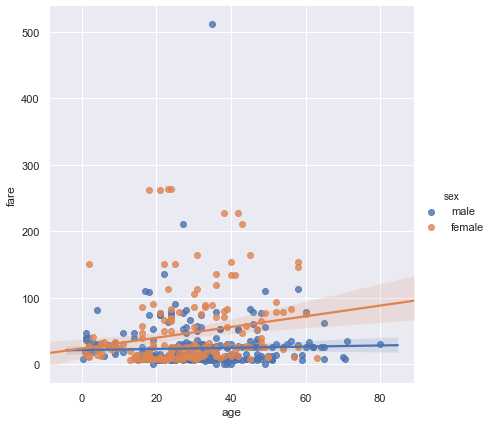

In [25]:
sns.lmplot(x="age", y="fare", hue="sex", data=titanic_train, size=6)

The slopes seem to be different for male and female. What does that indicate?

Let us now try to add an interaction effect into our model.

In [26]:
# It seemed like gender interacted with age and class. Can we put that in our model?
titanic_train['sex_male_X_age'] = titanic_train['age'] * titanic_train['sex_male']

model_3 = sm.OLS(
    titanic_train['fare'],
    sm.add_constant(titanic_train[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age']])
).fit()
model_3.summary()

KeyError: 'sex_male'

**What happened to the `age` and `male` terms?**

In [ ]:
# It seemed like gender interacted with age and class. Can we put that in our model?
titanic_train['sex_male_X_class_Second'] = titanic_train['age'] * titanic_train['class_Second']
titanic_train['sex_male_X_class_Third'] = titanic_train['age'] * titanic_train['class_Third']

model_4 = sm.OLS(
    titanic_train['fare'],
    sm.add_constant(titanic_train[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age', 
                             'sex_male_X_class_Second', 'sex_male_X_class_Third']])
).fit()
model_4.summary()

## Polynomial Regression 

![poly](../fig/poly.png)

Perhaps we now believe that the fare also depends on the square of age. How would we include this term in our model?

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(titanic_train['age'], titanic_train['fare'], 'o')
x = np.linspace(0,80,100)
ax.plot(x, x, '-', label=r'$y=x$')
ax.plot(x, 0.04*x**2, '-', label=r'$y=c x^2$')
ax.set_title('Plotting Age (x) vs Fare (y)')
ax.set_xlabel('Age (x)')
ax.set_ylabel('Fare (y)')
ax.legend();

**Exercise**: Create a model that predicts fare from all the predictors in `model_4` + the square of age. Show the summary of this model. Call it `model_5`. Remember to use the training data, `titanic_train`.

In [ ]:
# your code here



In [ ]:
# %load 'solutions/sol6.py'

## Looking at All Our Models: Model Selection

What has happened to the $R^2$ as we added more features? Does this mean that the model is better? (What if we kept adding more predictors and interaction terms? **In general, how should we choose a model?** We will spend a lot more time on model selection and learn about ways to do so as the course progresses.

In [ ]:
models = [model_1, model_2, model_3, model_4, model_5]
fig, ax = plt.subplots(figsize=(12,6))
ax.plot([model.df_model for model in models], [model.rsquared for model in models], 'x-')
ax.set_xlabel("Model degrees of freedom")
ax.set_title('Model degrees of freedom vs training $R^2$')
ax.set_ylabel("$R^2$");

**What about the test data?**

We added a lot of columns to our training data and must add the same to our test data in order to calculate $R^2$ scores.

In [ ]:
# Added features for model 1
# Nothing new to be added

# Added features for model 2
titanic_test = pd.get_dummies(titanic_test, columns=['sex', 'class'], drop_first=True)

# Added features for model 3
titanic_test['sex_male_X_age'] = titanic_test['age'] * titanic_test['sex_male']

# Added features for model 4
titanic_test['sex_male_X_class_Second'] = titanic_test['age'] * titanic_test['class_Second']
titanic_test['sex_male_X_class_Third'] = titanic_test['age'] * titanic_test['class_Third']

# Added features for model 5
titanic_test['age^2'] = titanic_test['age'] **2

**Calculating R^2 scores**

In [ ]:
from sklearn.metrics import r2_score

r2_scores = []
y_preds = []
y_true = titanic_test['fare']

# model 1
y_preds.append(model_1.predict(sm.add_constant(titanic_test['age'])))

# model 2
y_preds.append(model_2.predict(sm.add_constant(titanic_test[['age', 'sex_male', 'class_Second', 'class_Third']])))

# model 3
y_preds.append(model_3.predict(sm.add_constant(titanic_test[['age', 'sex_male', 'class_Second', 'class_Third', 
                                                              'sex_male_X_age']])))

# model 4
y_preds.append(model_4.predict(sm.add_constant(titanic_test[['age', 'sex_male', 'class_Second', 'class_Third', 
                                                              'sex_male_X_age', 'sex_male_X_class_Second', 
                                                              'sex_male_X_class_Third']])))

# model 5
y_preds.append(model_5.predict(sm.add_constant(titanic_test[['age', 'sex_male', 'class_Second', 
                                                              'class_Third', 'sex_male_X_age', 
                                                              'sex_male_X_class_Second', 
                                                              'sex_male_X_class_Third', 'age^2']])))

for y_pred in y_preds:
    r2_scores.append(r2_score(y_true, y_pred))
    
models = [model_1, model_2, model_3, model_4, model_5]
fig, ax = plt.subplots(figsize=(12,6))
ax.plot([model.df_model for model in models], r2_scores, 'x-')
ax.set_xlabel("Model degrees of freedom")
ax.set_title('Model degrees of freedom vs test $R^2$')
ax.set_ylabel("$R^2$");

## Regression Assumptions. Should We Even Regress Linearly?

![linear regression](../fig/linear_regression.png)

**Question**: What are the assumptions of a linear regression model? 

We find that the answer to this question can be found on closer examimation of $\epsilon$. What is $\epsilon$? It is assumed that $\epsilon$ is normally distributed with a mean of 0 and variance $\sigma^2$. But what does this tell us?

1. Assumption 1: Constant variance of $\epsilon$ errors. This means that if we plot our **residuals**, which are the differences between the true $Y$ and our predicted $\hat{Y}$, they should look like they have constant variance and a mean of 0. We will show this in our plots.
2. Assumption 2: Independence of $\epsilon$ errors. This again comes from the distribution of $\epsilon$ that we decide beforehand.
3. Assumption 3: Linearity. This is an implicit assumption as we claim that Y can be modeled through a linear combination of the predictors. **Important Note:** Even though our predictors, for instance $X_2$, can be created by squaring or cubing another variable, we still use them in a linear equation as shown above, which is why polynomial regression is still a linear model.
4. Assumption 4: Normality. We assume that the $\epsilon$ is normally distributed, and we can show this in a histogram of the residuals.

**Exercise**: Calculate the residuals for model 5, our most recent model. Optionally, plot and histogram these residuals and check the assumptions of the model.

In [ ]:
# your code here



In [ ]:
# %load 'solutions/sol7.py'

**What can you say about the assumptions of the model?**

----------------
### End of Standard Section
---------------

## Extra: Visual exploration of predictors'  correlations

The dataset for this problem contains 10 simulated predictors and a response variable. 

In [ ]:
# read in the data 
data = pd.read_csv('../data/dataset3.txt')
data.head()

In [ ]:
# this effect can be replicated using the scatter_matrix function in pandas plotting
sns.pairplot(data);

Predictors x1, x2, x3 seem to be perfectly correlated while predictors x4, x5, x6, x7 seem correlated.

In [ ]:
data.corr()

In [ ]:
sns.heatmap(data.corr())

## Extra: A Handy Matplotlib Guide

![](https://i.imgur.com/XTzSuoR.png)
source: http://matplotlib.org/faq/usage_faq.html

See also [this](http://matplotlib.org/faq/usage_faq.html) matplotlib tutorial.

![violin plot](../fig/violin.png)

See also [this](https://mode.com/blog/violin-plot-examples) violin plot tutorial.

---